# Fuel consumption dataset

This notebook explores the datasets from  https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64 between 1995 and 2022


# TO DO
Selecting the features can be left to the caller, or can be automated e.g. apply a chi-squared statistical test to rank the impact of each feature on the concept label and discard the less impactful features prior to model training.

In [1]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

import sys, os
sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))

In [58]:
def box_plot(dataframe, col_list_float, plot_kind):
    """
    This function generates boxplots to show distribution and outliers of various parameters
    """
    
   
    x_val = 1
    y_val = len(col_list_float)
        
    if len(dataframe['model_year'].unique()) ==1:
        title_year = dataframe['model_year'].min()
    else:
        title_year = f'{dataframe["model_year"].min()} - {dataframe["model_year"].max()}'
        
    fig1, axes = plt.subplots(x_val,y_val , sharey=True, figsize=(18,6))
    
    k=0
    for i in range(0,x_val):
        for j in range(0,y_val):

            variable= col_list_float[k].lower()
            if plot_kind=="box":
                sns.boxplot(ax=axes[j], data=dataframe, x=variable)
                fig1.suptitle(f'Outlier identification by vehicle class {title_year}')
            elif plot_kind=="hist":
                sns.distplot( dataframe[variable], ax=axes[j],bins=10)
                fig1.suptitle(f'Distribution of data {title_year}')
            k+=1
    plt.show()

In [59]:
def find_outliers_tukey(x):
    
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indeces = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indeces])
    
    return outlier_values

def find_outliers_kde(x):
    x_scaled = scale(list(map(float,x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw='scott',fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred<0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    
    return outlier_value

### Read data

In [60]:


paths = sys.path
clean_path = [item for item in paths if "machine-learning-capstone\\data\\clean-data" in item]
clean_data = clean_path[0]

file_name_2022_1995 = "1995_2022_vehicle_fuel_consumption.csv"

In [61]:


# Master df
master_df = pd.read_csv(Path(clean_data,f'{file_name_2022_1995}'))

## Clean data

In [62]:
#master_df = pd.get_dummies(master_df, columns=['transmission_type', 'mapped_fuel_type'])

#### NaN values in CO2 rating and smog rating columns are due to non-existing ratings between the years 1995 - 2015

In [63]:
master_df

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,type_of_wheel_drive
0,2022,acura,ilx,compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,200,6.0,3.0,automated manual,8.0,premium gasoline,unspecified
1,2022,acura,mdx sh-awd,suv - small,3.5,6.0,AS10,Z,12.6,9.4,11.2,25,263,4.0,5.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
2,2022,acura,rdx sh-awd,suv - small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
3,2022,acura,rdx sh-awd a-spec,suv - small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
4,2022,acura,tlx sh-awd,compact,2.0,4.0,AS10,Z,11.2,8.0,9.8,29,230,5.0,7.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26154,1999,volvo,v70 t5 turbo wagon,station wagon - mid-size,2.3,5.0,A4,Z,13.4,9.4,11.6,24,267,NaN,NaN,automatic,4.0,premium gasoline,unspecified
26155,1999,volvo,v70 t5 turbo wagon,station wagon - mid-size,2.3,5.0,M5,Z,13.4,9.4,11.6,24,267,NaN,NaN,manual,5.0,premium gasoline,unspecified
26156,1999,volvo,v70 wagon,station wagon - mid-size,2.4,5.0,A4,Z,13.1,9.1,11.3,25,260,NaN,NaN,automatic,4.0,premium gasoline,unspecified
26157,1999,volvo,v70 wagon,station wagon - mid-size,2.4,5.0,M5,Z,12.7,9.0,11.0,26,253,NaN,NaN,manual,5.0,premium gasoline,unspecified


## Summary stats

In [64]:
master_df.describe()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,number_of_gears
count,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,26159.000000,7171.000000,6061.000000,25343.000000
mean,2009.587370,3.354199,5.843840,13.887714,10.031358,12.152433,24.854696,276.113498,4.659880,4.674311,5.751134
std,7.714509,1.341689,1.797738,3.743958,2.596064,3.190843,6.690956,65.868107,1.638001,1.791209,1.489783
min,1995.000000,0.800000,2.000000,4.000000,3.900000,4.000000,10.000000,94.000000,1.000000,1.000000,1.000000
25%,2004.000000,2.300000,4.000000,11.300000,8.300000,10.000000,20.000000,230.000000,4.000000,3.000000,5.000000
50%,2010.000000,3.000000,6.000000,13.400000,9.600000,11.700000,24.000000,269.000000,5.000000,5.000000,6.000000
75%,2016.000000,4.200000,8.000000,16.000000,11.400000,13.900000,28.000000,315.000000,6.000000,6.000000,6.000000
max,2022.000000,8.400000,16.000000,33.300000,22.100000,27.500000,71.000000,633.000000,10.000000,8.000000,10.000000


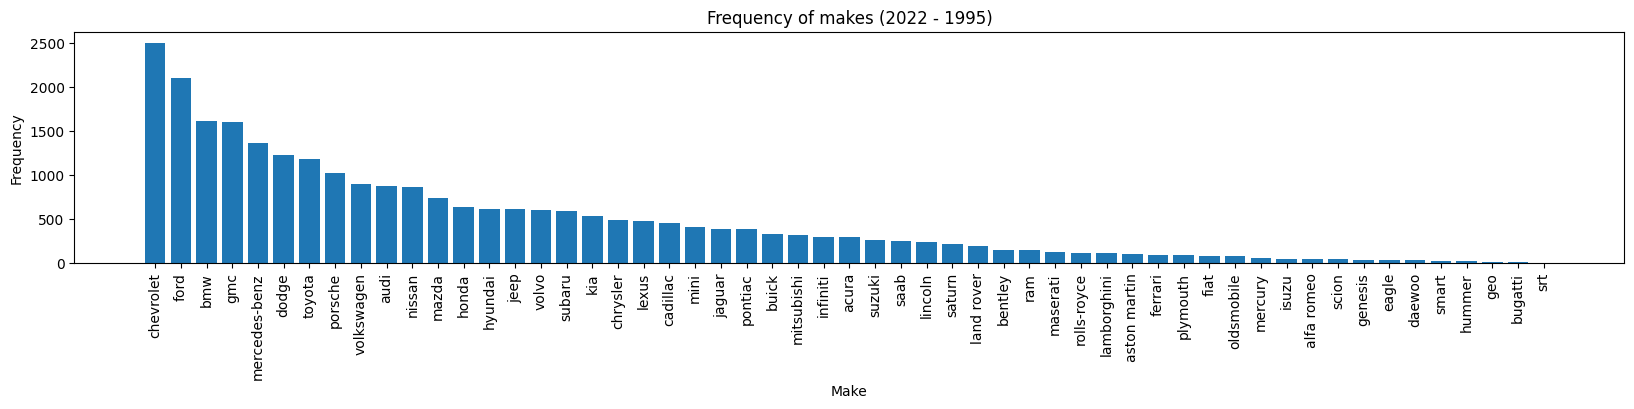

In [65]:
models = master_df.groupby("make_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(x = models['make_'], height = models['count'])
plt.xticks(rotation=90)
plt.xlabel("Make")
plt.ylabel("Frequency")
plt.title("Frequency of makes (2022 - 1995)")
plt.show()

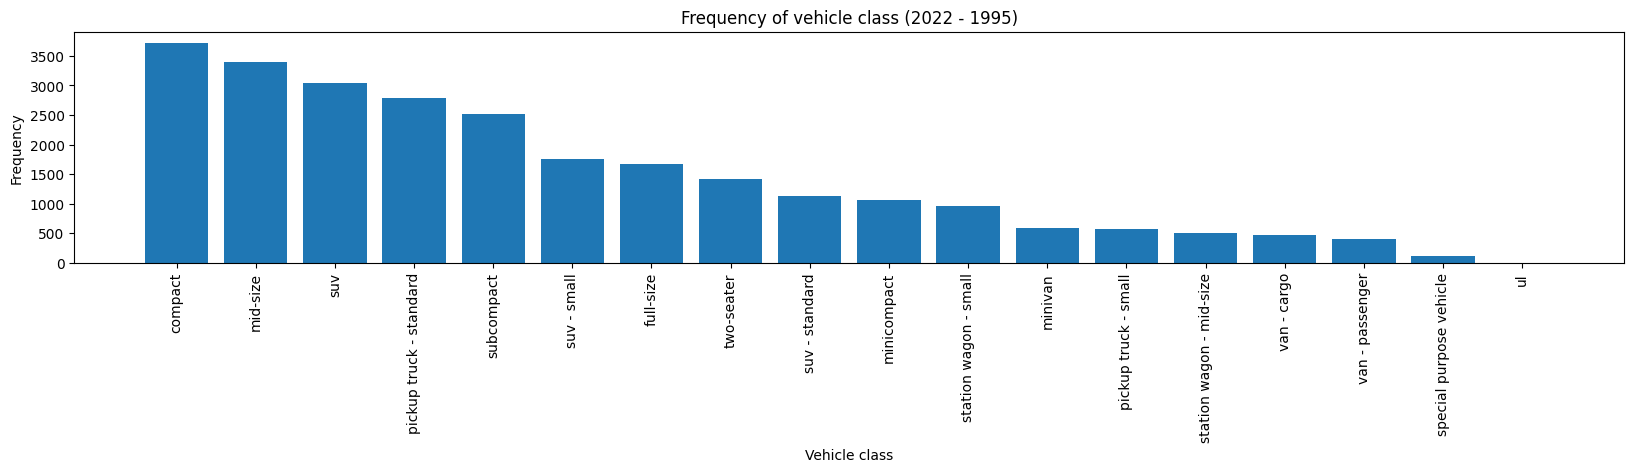

In [66]:
vehicle_class = master_df.groupby("vehicleclass_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(x = vehicle_class['vehicleclass_'], height = vehicle_class['count'])
plt.xticks(rotation=90)
plt.xlabel("Vehicle class")
plt.ylabel("Frequency")
plt.title("Frequency of vehicle class (2022 - 1995)")
plt.show()

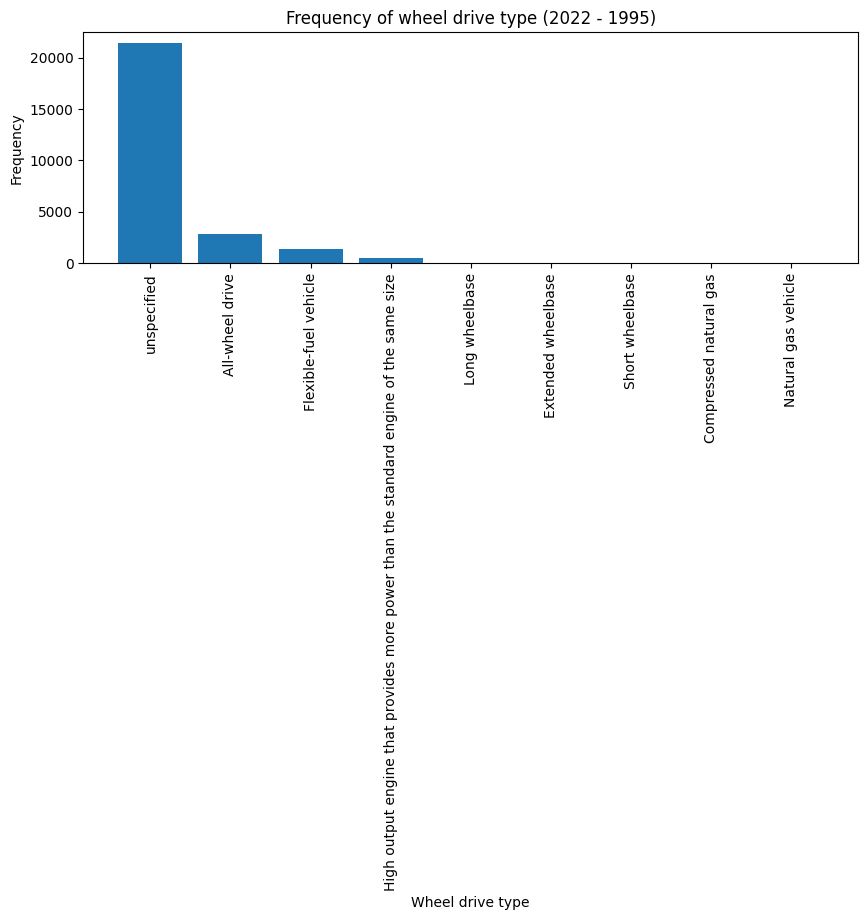

In [67]:
wheel_drive = master_df.groupby("type_of_wheel_drive").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,3)
plt.bar(x = wheel_drive['type_of_wheel_drive'], height = wheel_drive['count'])
plt.xticks(rotation=90)
plt.xlabel("Wheel drive type")
plt.ylabel("Frequency")
plt.title("Frequency of wheel drive type (2022 - 1995)")
plt.show()

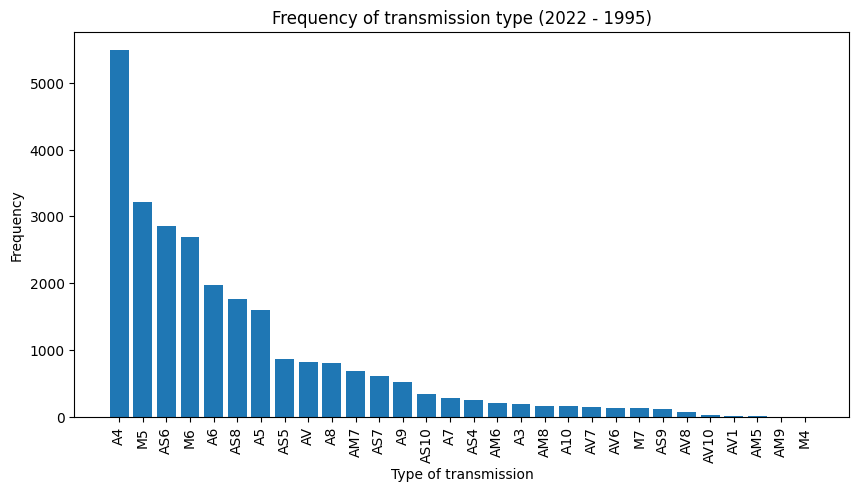

In [68]:
transmission = master_df.groupby("transmission_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = transmission['transmission_'], height = transmission['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of transmission")
plt.ylabel("Frequency")
plt.title("Frequency of transmission type (2022 - 1995)")
plt.show()

In [69]:
master_df


,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,type_of_wheel_drive
0,2022,acura,ilx,compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,200,6.0,3.0,automated manual,8.0,premium gasoline,unspecified
1,2022,acura,mdx sh-awd,suv - small,3.5,6.0,AS10,Z,12.6,9.4,11.2,25,263,4.0,5.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
2,2022,acura,rdx sh-awd,suv - small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
3,2022,acura,rdx sh-awd a-spec,suv - small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
4,2022,acura,tlx sh-awd,compact,2.0,4.0,AS10,Z,11.2,8.0,9.8,29,230,5.0,7.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26154,1999,volvo,v70 t5 turbo wagon,station wagon - mid-size,2.3,5.0,A4,Z,13.4,9.4,11.6,24,267,NaN,NaN,automatic,4.0,premium gasoline,unspecified
26155,1999,volvo,v70 t5 turbo wagon,station wagon - mid-size,2.3,5.0,M5,Z,13.4,9.4,11.6,24,267,NaN,NaN,manual,5.0,premium gasoline,unspecified
26156,1999,volvo,v70 wagon,station wagon - mid-size,2.4,5.0,A4,Z,13.1,9.1,11.3,25,260,NaN,NaN,automatic,4.0,premium gasoline,unspecified
26157,1999,volvo,v70 wagon,station wagon - mid-size,2.4,5.0,M5,Z,12.7,9.0,11.0,26,253,NaN,NaN,manual,5.0,premium gasoline,unspecified


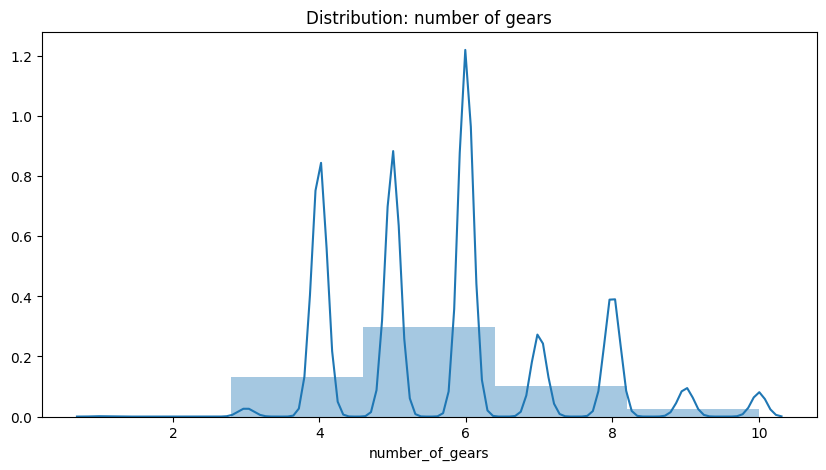

In [70]:
sns.distplot(master_df['number_of_gears'], bins=5)
plt.title("Distribution: number of gears")
plt.show()

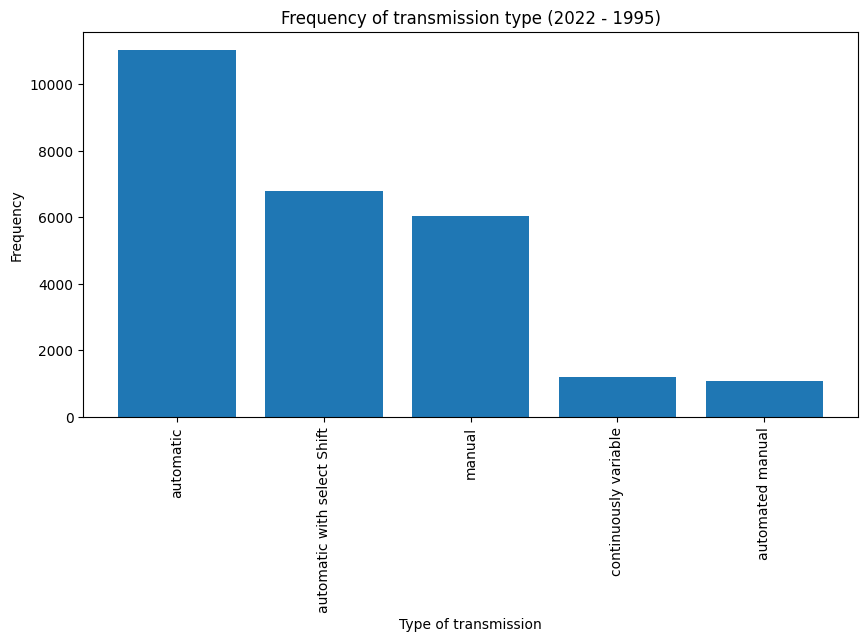

In [71]:
transmission_type = master_df.groupby("transmission_type").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = transmission_type['transmission_type'], height = transmission_type['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of transmission")
plt.ylabel("Frequency")
plt.title("Frequency of transmission type (2022 - 1995)")
plt.show()

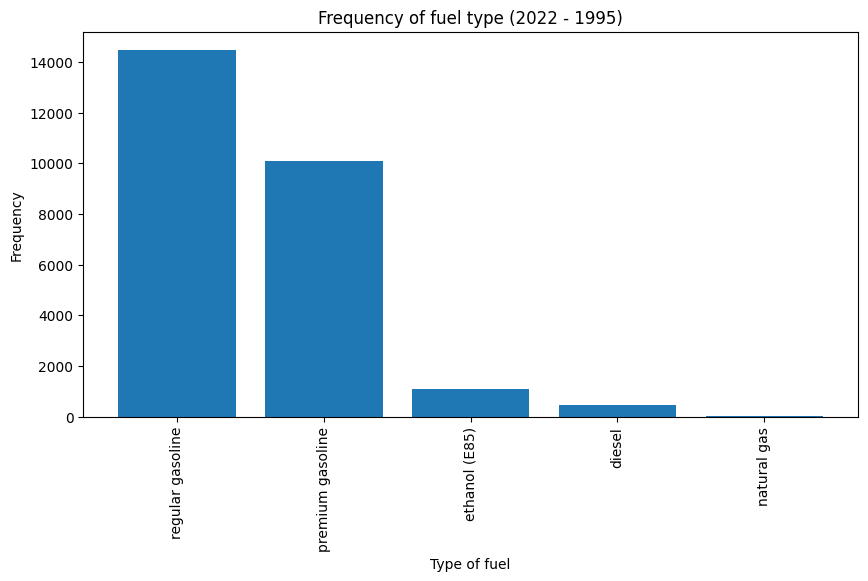

In [72]:
fuel_type = master_df.groupby("mapped_fuel_type").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = fuel_type['mapped_fuel_type'], height = fuel_type['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of fuel")
plt.ylabel("Frequency")
plt.title("Frequency of fuel type (2022 - 1995)")
plt.show()

### Outliers and scaling

In [73]:


fuel_info = [
              'fuelconsumption_city(l/100km)','fuelconsumption_hwy(l/100km)',	
              'fuelconsumption_comb(l/100km)','fuelconsumption_comb(mpg)',
                  ]     

engine_info  = ['enginesize_(l)','cylinders_','co2_rating','co2emissions_(g/km)','smog_rating']

In [74]:
outliers = {}
for item in fuel_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df[item]))
    print(item, len(outliers[item]))
    
for item in engine_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df[item]))
    print(item, len(outliers[item]))

fuelconsumption_city(l/100km) 557
fuelconsumption_hwy(l/100km) 649
fuelconsumption_comb(l/100km) 605
fuelconsumption_comb(mpg) 527
enginesize_(l) 48
cylinders_ 12
co2_rating 0
co2emissions_(g/km) 336
smog_rating 0


### The data has a positive skew

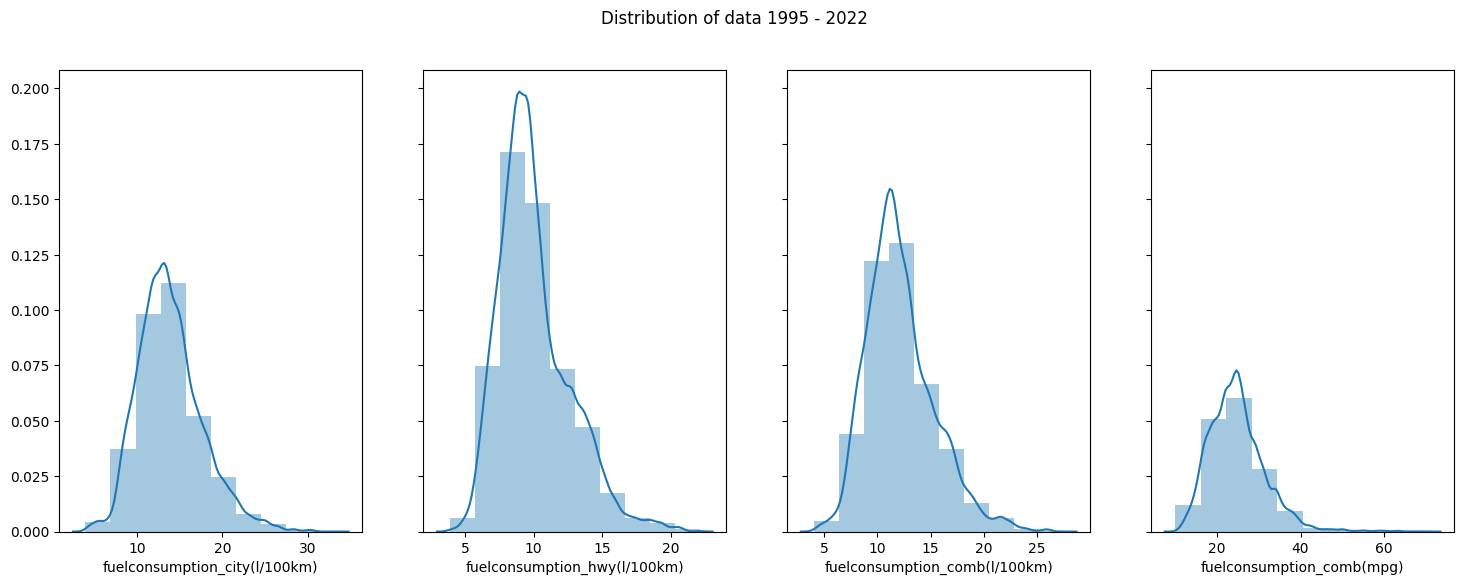

In [75]:

box_plot(master_df,fuel_info,"hist")

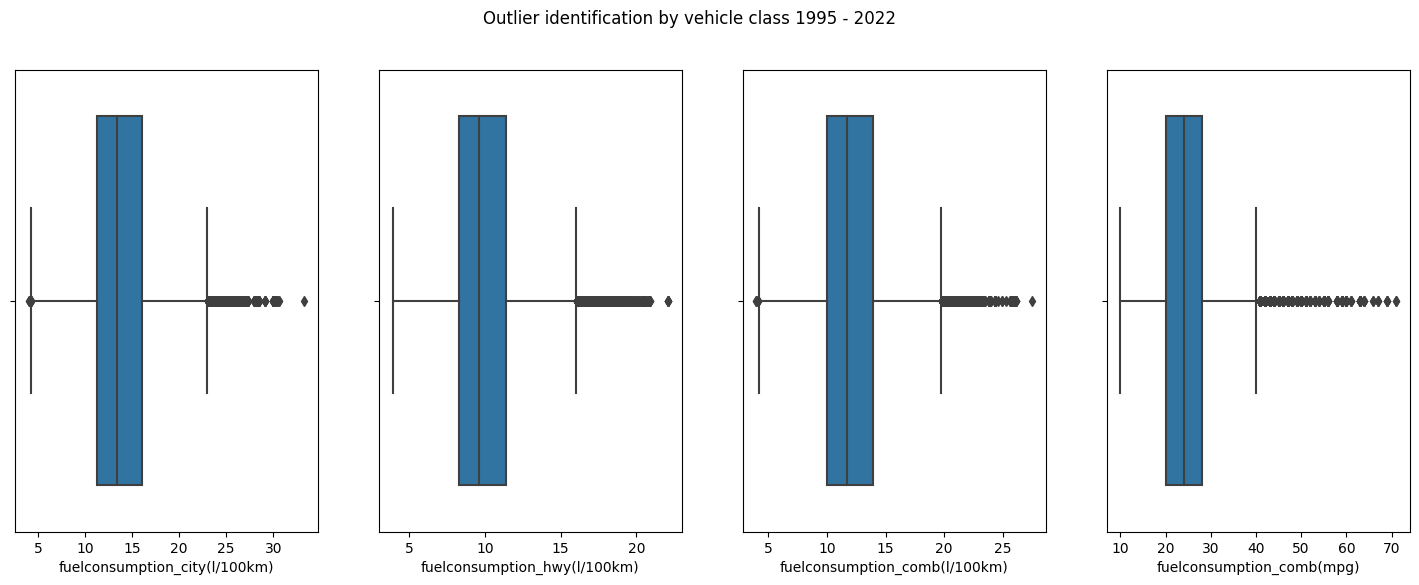

In [76]:
box_plot(master_df,fuel_info,"box")

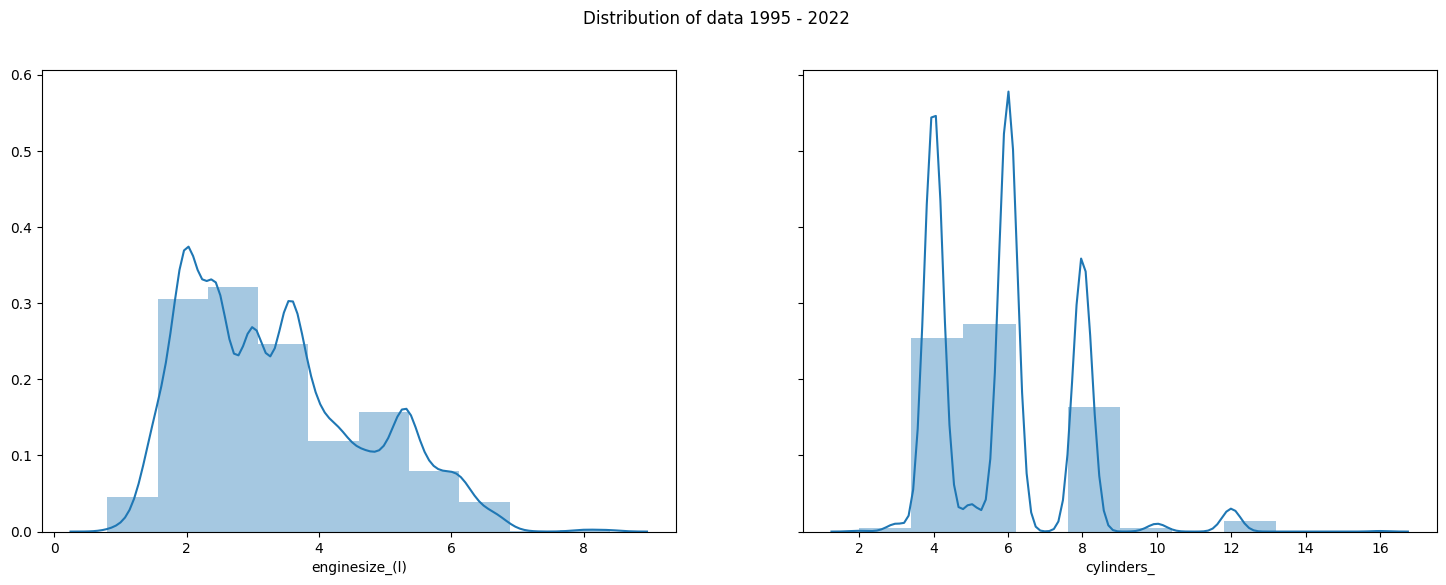

In [77]:
engine_info  = ['EngineSize_(L)','Cylinders_']
box_plot(master_df,engine_info,'hist')

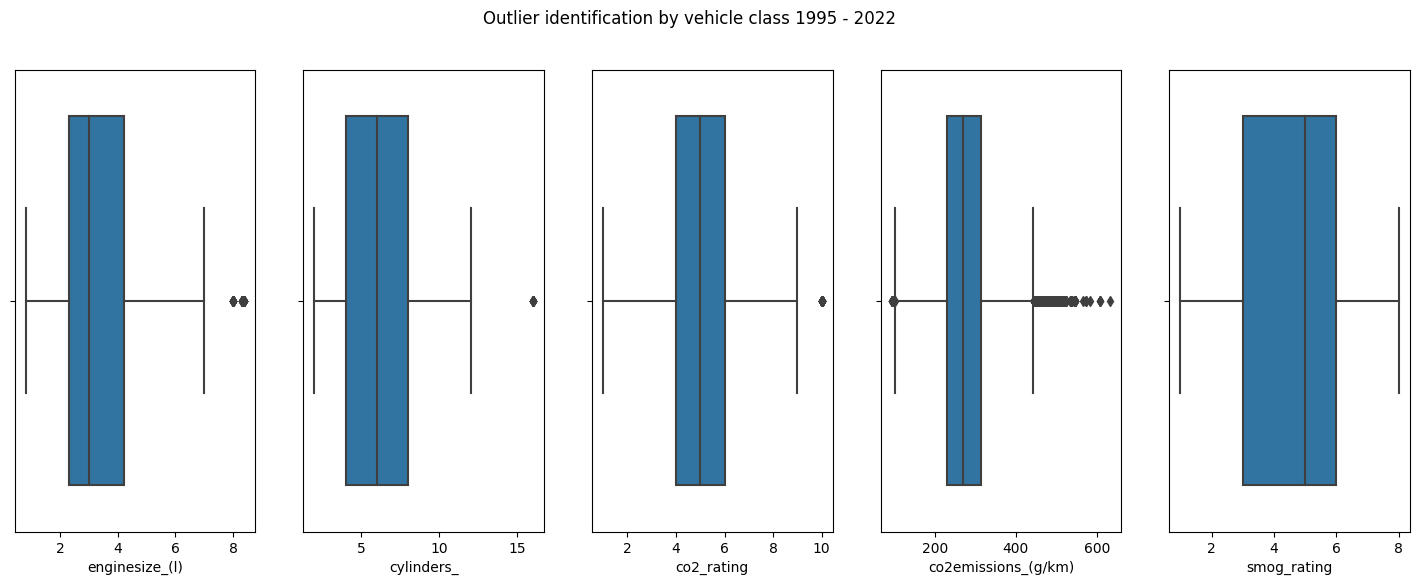

In [78]:
engine_info  = ['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)','smog_rating']
box_plot(master_df,engine_info,'box')

In [79]:
master_df[~master_df['co2_rating'].isna()]

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,type_of_wheel_drive
0,2022,acura,ilx,compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,200,6.0,3.0,automated manual,8.0,premium gasoline,unspecified
1,2022,acura,mdx sh-awd,suv - small,3.5,6.0,AS10,Z,12.6,9.4,11.2,25,263,4.0,5.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
2,2022,acura,rdx sh-awd,suv - small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
3,2022,acura,rdx sh-awd a-spec,suv - small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
4,2022,acura,tlx sh-awd,compact,2.0,4.0,AS10,Z,11.2,8.0,9.8,29,230,5.0,7.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7166,2016,volvo,xc70 t5,suv - small,2.0,4.0,AS8,X,10.3,7.6,9.1,31,213,6.0,NaN,automatic with select Shift,8.0,regular gasoline,unspecified
7167,2016,volvo,xc70 t5 awd,suv - small,2.5,5.0,AS6,X,12.5,9.2,11.0,26,254,5.0,NaN,automatic with select Shift,6.0,regular gasoline,All-wheel drive
7168,2016,volvo,xc90 t5,suv - standard,2.0,4.0,AS8,Z,10.6,9.1,10.0,28,232,5.0,NaN,automatic with select Shift,8.0,premium gasoline,unspecified
7169,2016,volvo,xc90 t5 awd,suv - standard,2.0,4.0,AS8,Z,10.8,9.5,10.2,28,239,5.0,NaN,automatic with select Shift,8.0,premium gasoline,All-wheel drive


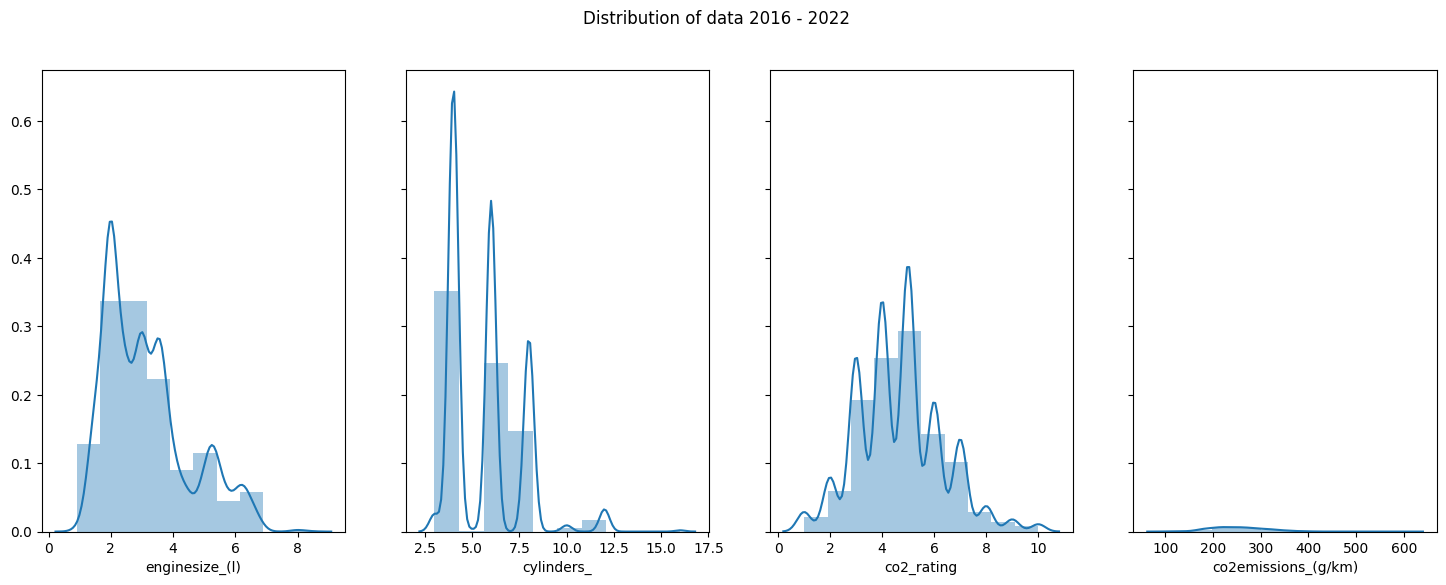

In [80]:
non_na_rating = master_df[~master_df['co2_rating'].isna()]
box_plot(non_na_rating,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"hist")

### Using natural logarithm

In [81]:
master_df_log_app = master_df.copy()

In [82]:
fuel_info = [
              'fuelconsumption_city(l/100km)','fuelconsumption_hwy(l/100km)',	
              'fuelconsumption_comb(l/100km)','fuelconsumption_comb(mpg)',]
    
engine_info  = ['enginesize_(l)','co2emissions_(g/km)','smog_rating']

In [83]:
for item in fuel_info:
    master_df_log_app[item] = master_df_log_app[item].apply(lambda x: np.log(x))
    
for item in engine_info:
    master_df_log_app[item] = master_df_log_app[item].apply(lambda x: np.log(x))

In [84]:
master_df_log_app.head()

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,type_of_wheel_drive
0,2022,acura,ilx,compact,0.875469,4.0,AM8,Z,2.292535,1.945910,2.151762,3.496508,5.298317,6.0,1.098612,automated manual,8.0,premium gasoline,unspecified
1,2022,acura,mdx sh-awd,suv - small,1.252763,6.0,AS10,Z,2.533697,2.240710,2.415914,3.218876,5.572154,4.0,1.609438,automatic with select Shift,10.0,premium gasoline,All-wheel drive
2,2022,acura,rdx sh-awd,suv - small,0.693147,4.0,AS10,Z,2.397895,2.151762,2.292535,3.367296,5.446737,5.0,1.791759,automatic with select Shift,10.0,premium gasoline,All-wheel drive
3,2022,acura,rdx sh-awd a-spec,suv - small,0.693147,4.0,AS10,Z,2.424803,2.208274,2.332144,3.295837,5.488938,5.0,1.791759,automatic with select Shift,10.0,premium gasoline,All-wheel drive
4,2022,acura,tlx sh-awd,compact,0.693147,4.0,AS10,Z,2.415914,2.079442,2.282382,3.367296,5.438079,5.0,1.945910,automatic with select Shift,10.0,premium gasoline,All-wheel drive


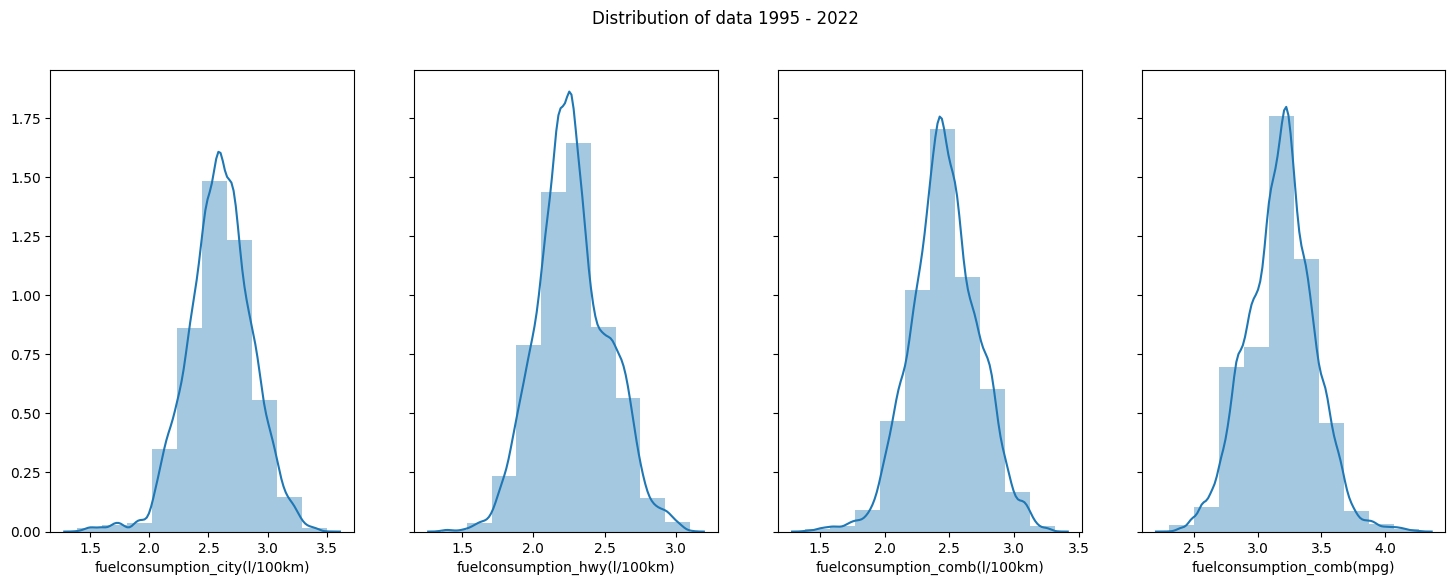

In [85]:
box_plot(master_df_log_app,fuel_info,"hist")


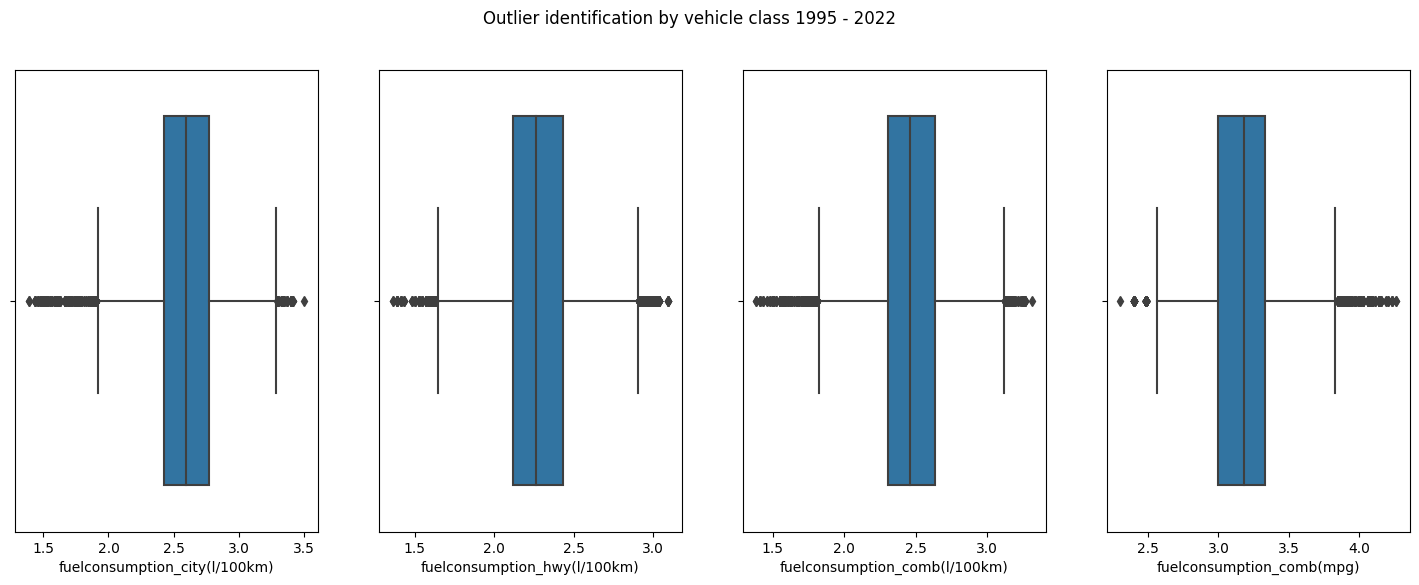

In [86]:
box_plot(master_df_log_app,fuel_info,"box")

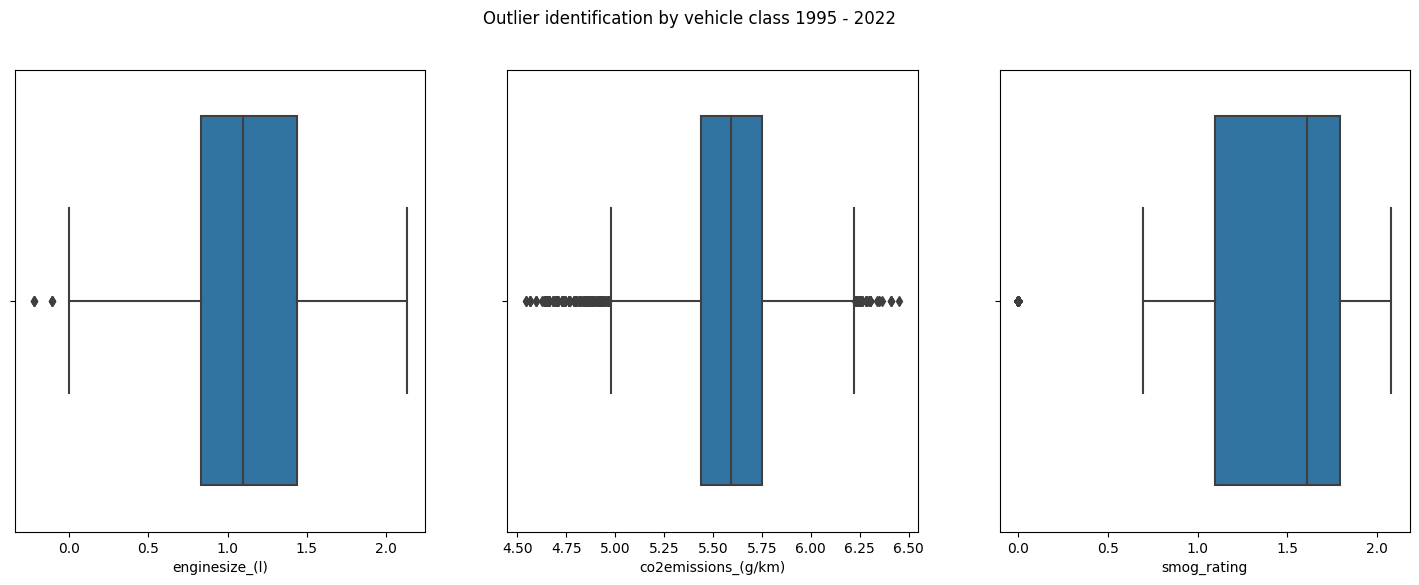

In [87]:
box_plot(master_df_log_app,engine_info,"box")

In [88]:
outliers_log = {}
for item in fuel_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df_log_app[item]))
    print(item, len(outliers[item]))
    
for item in ['enginesize_(l)','cylinders_','co2_rating','co2emissions_(g/km)']:
    outliers[item] = np.sort(find_outliers_tukey(master_df_log_app[item]))
    print(item, len(outliers[item]))

fuelconsumption_city(l/100km) 377
fuelconsumption_hwy(l/100km) 348
fuelconsumption_comb(l/100km) 371
fuelconsumption_comb(mpg) 385
enginesize_(l) 6
cylinders_ 12
co2_rating 0
co2emissions_(g/km) 305


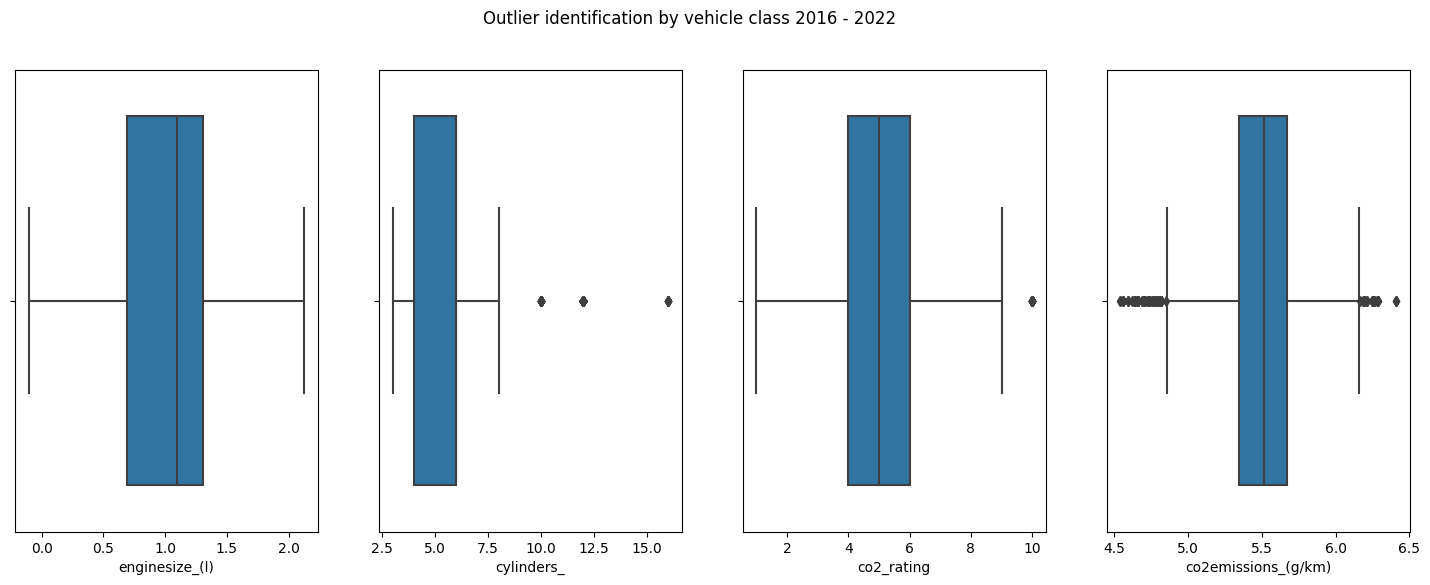

In [89]:
non_na_rating_log = master_df_log_app[~master_df_log_app['co2_rating'].isna()]
box_plot(non_na_rating_log,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"box")

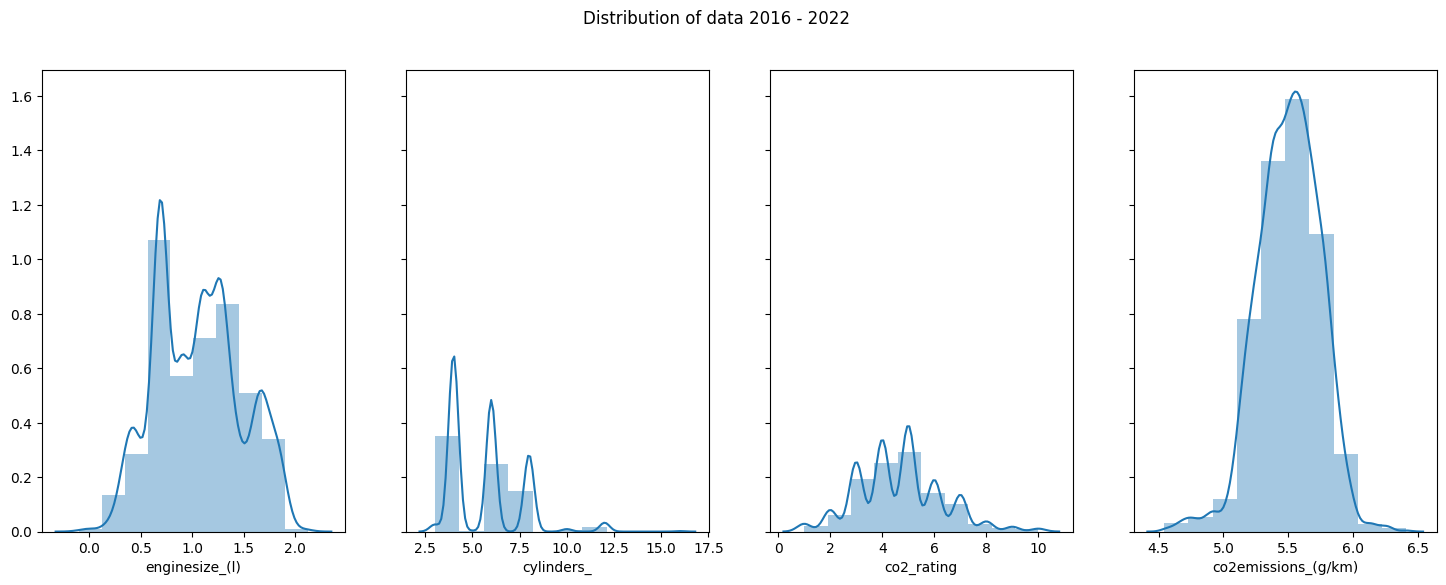

In [90]:
box_plot(non_na_rating_log,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"hist")

In [50]:
corr_matrix_non_na_log = non_na_rating_log.corr()



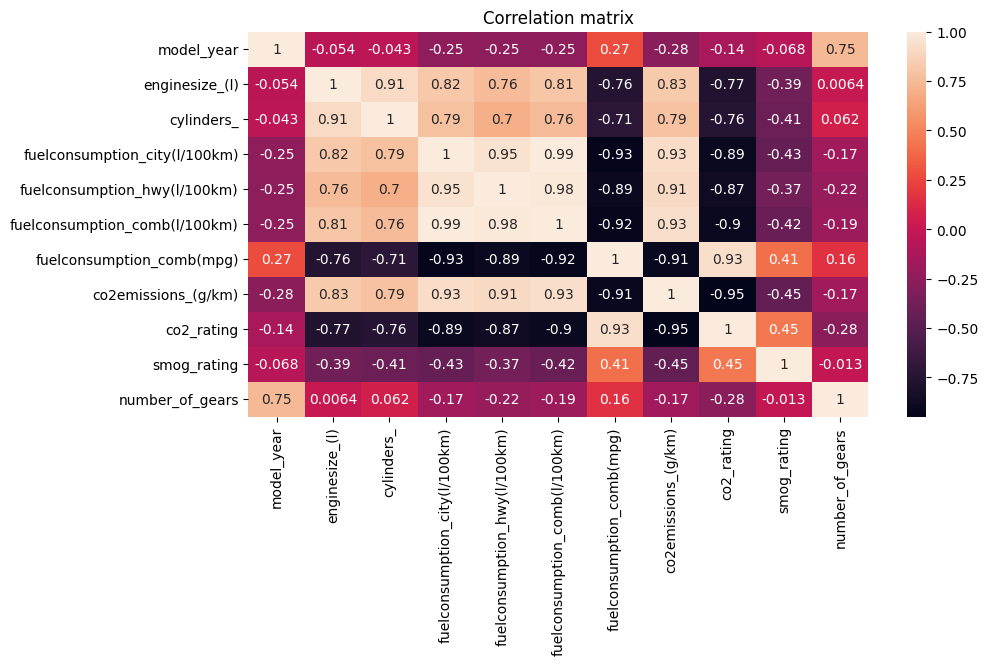

In [51]:
corr_matrix = master_df.corr()
fig_corr = sns.heatmap(corr_matrix, annot=True)
fig_corr.figure.savefig("./plots/correlation_matrix.png") 
plt.title("Correlation matrix")
plt.show()

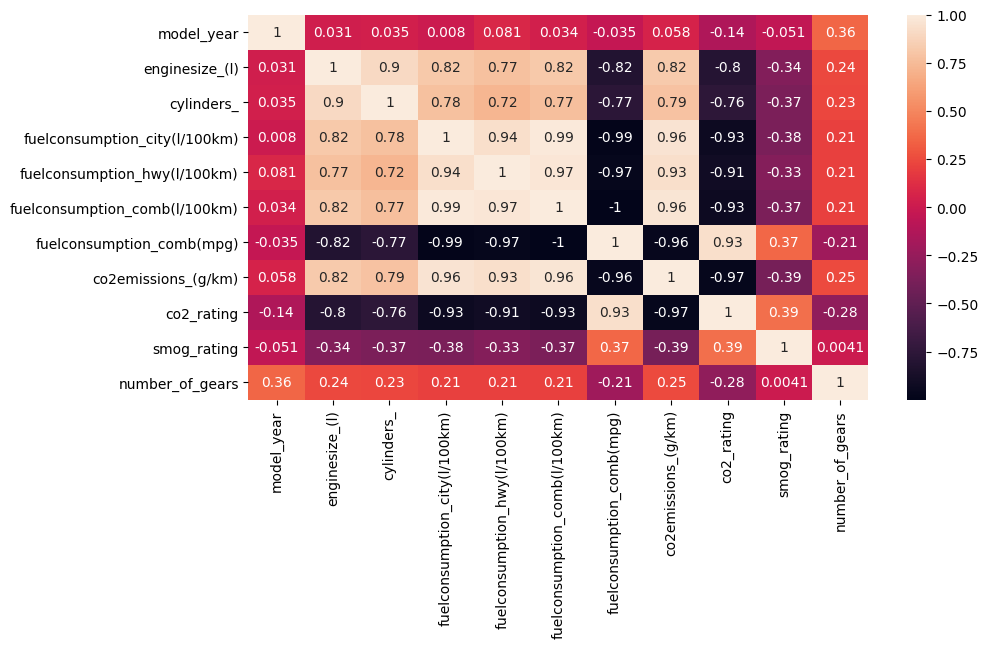

In [53]:
sns.heatmap(corr_matrix_non_na_log, annot=True)

plt.show()

## Predicting CO2 ratings for remaining values - feature engineering

#### Target variable: co2_rating

#### Independent variables: 

1. engine_size(l),

2. fuelconsumption_city(l/100km), 

3. fuelconsumption_hwy(l/100km),

4. fuelconsumption_comb(l/100km),

5. fuelconsumption_comb(mpg)

6. co2emissions_(g/km)

7. (maybe) cylinders_ 

In [ ]:
master_df

In [ ]:
master_df_log_app = master_df.copy()
entries_with_scores = master_df_log_app[master_df_log_app['model_year']>=2017]
entries_with_scores.isna().sum()

In [ ]:
#fig = sns.pairplot(entries_with_scores, hue="type_of_fuel")
#fig.savefig("./plots/pairplot-by-fuel-type.png") 
#plt.show()

In [ ]:
#entries_with_scores['co2_rating'] = entries_with_scores['co2_rating'].astype('int').astype('str')

In [ ]:
entries_with_scores['co2_rating'].unique()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer

kf = KFold(n_splits=10)
folds = StratifiedGroupKFold(n_splits=10)

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [ ]:
Y = entries_with_scores['co2_rating']

X = entries_with_scores[['enginesize_(l)','cylinders_','fuelconsumption_city(l/100km)',
                         'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)', 
                         'fuelconsumption_comb(mpg)','co2emissions_(g/km)']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
lr_sc = []
sv_sc = []
rf_sc = []
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index],\
                                        Y.iloc[train_index], Y.iloc[test_index] 
    lr_sc.append(get_score(LinearRegression(), X_train, X_test, y_train, y_test))
    
    ### NEED TO REVIEW https://scikit-learn.org/stable/modules/preprocessing.html
    sv_sc.append(get_score(GradientBoostingRegressor(), X_train, X_test, y_train, y_test))
    rf_sc.append(get_score(RandomForestClassifier(), X_train, X_test, y_train, y_test))

### Try xgboost, lightgbm 

### Next, try neural network model

In [ ]:
lr_sc

In [ ]:
sv_sc

In [ ]:
rf_sc

In [ ]:
cross_val_score(LinearRegression(), X, Y)

In [ ]:
cross_val_score(GradientBoostingRegressor(n_estimators=40), X, Y)

In [ ]:
cross_val_score(RandomForestClassifier(n_estimators=100), X, Y)

#### Predicting

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_predictions = lm.predict(X_test)


gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gmb_predictions = gbm.predict(X_test)

In [ ]:
lm_mae = mean_absolute_error(lm_predictions, y_test)
# lm_rmse = np.sqrt(mean_squared_error(lm_predictions, y_test),y_test)

gbm_mae = mean_absolute_error(gmb_predictions, y_test)
# gbm_rmse = np.sqrt(mean_squared_error(gmb_predictions, y_test), y_test)

In [ ]:
print(lm_mae)
print(gbm_mae)

GradientBoostingRegressor is slightly more accurate than gradient boosting.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, gmb_predictions)

Next: work on this as a classification problem instead
Use equivalent libraries when using XGB

Plot confusion matrix, look at F1 score, accuracy metrics

Once this is done, we can continue with the neural network implementation. 

Recommendation: start with Keras. 

Later we can look at TensorFlow or PyTorch. 
